<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/claude/drgreen-v2-01TfLAqRxjEF2BkLLt72vJrL/drgreen_v7_stratified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dr Green V7 - STRATIFIED Split (Critical Fix)

**V6 Problem: All validation samples were from ONE class (kinkeliba)**

This was caused by `image_dataset_from_directory` not doing stratified splits.

**V7 Fix:**
- Uses sklearn's `train_test_split` with `stratify` parameter
- Guarantees each class is represented in both train and validation
- Same architecture as V6 (MobileNetV2 + Focal Loss)

### Target: Proper evaluation across all 4 classes

## 1. Setup & Imports

In [2]:
# Install gdown for dataset download
!pip install -q gdown

# Core imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import zipfile
import os
import gdown
import glob

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Check GPU
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU detected - training will be fast!")
else:
    print("No GPU - training will be slow. Enable GPU in Runtime > Change runtime type")

TensorFlow version: 2.19.0
GPU available: True
GPU detected - training will be fast!


In [3]:
# Download dataset from Google Drive
file_id = '1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD'
url = f'https://drive.google.com/uc?id={file_id}'
output = '/content/drgreen.zip'

print("Downloading dataset from Google Drive...")
try:
    gdown.download(url, output, quiet=False)
    print("Dataset downloaded!")

    # Extract
    print("\nExtracting...")
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print("Dataset extracted!")
except:
    print("\nAuto-download failed. Please upload manually:")
    print("from google.colab import files")
    print("uploaded = files.upload()")

Downloading...
From (original): https://drive.google.com/uc?id=1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD
From (redirected): https://drive.google.com/uc?id=1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD&confirm=t&uuid=408aeab7-9830-4d05-b1f8-e37e81b52f9b
To: /content/drgreen.zip
100%|██████████| 232M/232M [00:03<00:00, 62.1MB/s]


Dataset downloaded!

Extracting...
Dataset extracted!


## 2. Configuration

In [7]:
# V7 Configuration - Same as V6 but with stratified split
CONFIG = {
    # Paths
    'data_dir': 'rename',
    'model_save_dir': 'models',

    # Image parameters
    'img_height': 224,
    'img_width': 224,
    'batch_size': 16,

    # Training parameters
    'epochs': 100,
    'initial_lr': 0.0005,

    'validation_split': 0.2,
    'seed': 42,

    # Model parameters
    'base_model': 'MobileNetV2',
    'dropout_rate': 0.6,  # Slightly lower than V6
    'num_classes': 4,
    'dense_units': 64,

    # Regularization
    'l2_reg': 0.02,
    'label_smoothing': 0.15,

    # Focal Loss parameters
    'focal_gamma': 2.0,
    'focal_alpha': 0.25,

    # Callbacks
    'early_stopping_patience': 15,
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'min_lr': 1e-7,
}

PLANT_CLASSES = ['artemisia', 'carica', 'goyavier', 'kinkeliba']
Path(CONFIG['model_save_dir']).mkdir(exist_ok=True)


print("Green v2 - STRATIFIED SPLIT")

print(f"\nBase Model: {CONFIG['base_model']} (FROZEN)")
print(f"Image Size: {CONFIG['img_height']}x{CONFIG['img_width']}")
print(f"Batch Size: {CONFIG['batch_size']}")

Green v2 - STRATIFIED SPLIT

Base Model: MobileNetV2 (FROZEN)
Image Size: 224x224
Batch Size: 16


## 3. Focal Loss Implementation

In [8]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, label_smoothing=0.0, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = y_true * (1.0 - self.label_smoothing) + (self.label_smoothing / num_classes)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_weight = tf.pow(1 - p_t, self.gamma)
        focal_loss = self.alpha * focal_weight * tf.reduce_sum(cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            'gamma': self.gamma,
            'alpha': self.alpha,
            'label_smoothing': self.label_smoothing
        })
        return config

print("Focal Loss implemented")

Focal Loss implemented


## 4. STRATIFIED Dataset Loading (Critical Fix)

In [9]:
# Get all image paths and labels
data_dir = Path(CONFIG['data_dir'])
class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
print(f"Classes found: {class_names}")

# Collect all image paths and labels
all_image_paths = []
all_labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        for img_path in class_dir.glob(ext):
            all_image_paths.append(str(img_path))
            all_labels.append(class_idx)

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print(f"\nTotal images: {len(all_image_paths)}")
for i, name in enumerate(class_names):
    count = (all_labels == i).sum()
    print(f"  {name}: {count} images")

Classes found: ['artemisia', 'carica', 'goyavier', 'kinkeliba']

Total images: 1164
  artemisia: 275 images
  carica: 356 images
  goyavier: 241 images
  kinkeliba: 292 images


In [12]:
# STRATIFIED SPLIT using sklearn
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=CONFIG['validation_split'],
    random_state=CONFIG['seed'],
    stratify=all_labels  # CRITICAL: This ensures balanced split!
)

print("STRATIFIED SPLIT RESULTS")

print(f"\nTraining set: {len(train_paths)} images")
for i, name in enumerate(class_names):
    count = (train_labels == i).sum()
    pct = count / len(train_labels) * 100
    print(f"  {name}: {count} images ({pct:.1f}%)")

print(f"\nValidation set: {len(val_paths)} images")
for i, name in enumerate(class_names):
    count = (val_labels == i).sum()
    pct = count / len(val_labels) * 100
    print(f"  {name}: {count} images ({pct:.1f}%)")

STRATIFIED SPLIT RESULTS

Training set: 931 images
  artemisia: 220 images (23.6%)
  carica: 285 images (30.6%)
  goyavier: 193 images (20.7%)
  kinkeliba: 233 images (25.0%)

Validation set: 233 images
  artemisia: 55 images (23.6%)
  carica: 71 images (30.5%)
  goyavier: 48 images (20.6%)
  kinkeliba: 59 images (25.3%)


In [13]:
# Create TensorFlow datasets from paths
def load_and_preprocess_image(path, label):
    # Load image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [CONFIG['img_height'], CONFIG['img_width']])
    return img, label

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Convert labels to one-hot
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, CONFIG['num_classes'])))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, CONFIG['num_classes'])))

print("Datasets created from stratified split")

Datasets created from stratified split


## 5. Data Augmentation & Pipeline

In [14]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.15, 0.15),
], name="data_augmentation")

# Preprocessing for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Apply augmentation and preprocessing
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)
train_ds = train_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

# Batch and optimize
train_ds = train_ds.shuffle(1000).batch(CONFIG['batch_size']).prefetch(AUTOTUNE)
val_ds = val_ds.batch(CONFIG['batch_size']).prefetch(AUTOTUNE)

print("Data pipeline configured")

Data pipeline configured


In [15]:
# Calculate class weights
total_train = len(train_labels)
class_weights = {}
for i, class_name in enumerate(class_names):
    count = (train_labels == i).sum()
    base_weight = total_train / (len(class_names) * count)
    class_weights[i] = base_weight ** 1.3  # Moderate power

print("Class weights:")
for i, weight in class_weights.items():
    print(f"  {class_names[i]}: {weight:.3f}")

Class weights:
  artemisia: 1.076
  carica: 0.769
  goyavier: 1.276
  kinkeliba: 0.999


## 6. Build Model

In [16]:
def build_model():
    inputs = tf.keras.Input(shape=(CONFIG['img_height'], CONFIG['img_width'], 3))

    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.Dropout(CONFIG['dropout_rate'])(x)
    x = tf.keras.layers.Dense(
        CONFIG['dense_units'],
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(CONFIG['l2_reg']),
        kernel_initializer='he_normal'
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(CONFIG['dropout_rate'] * 0.5)(x)
    outputs = tf.keras.layers.Dense(
        CONFIG['num_classes'],
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(CONFIG['l2_reg'])
    )(x)

    model = tf.keras.Model(inputs, outputs, name='DrGreen_V7_Stratified')
    return model, base_model

model, base_model = build_model()

print("\nModel Architecture:")
print(f"  Base: {CONFIG['base_model']} (FROZEN)")
print(f"  Total parameters: {model.count_params():,}")
trainable = sum([tf.size(v).numpy() for v in model.trainable_variables])
print(f"  Trainable parameters: {trainable:,}")

/tmp/ipython-input-3071338007.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Model Architecture:
  Base: MobileNetV2 (FROZEN)
  Total parameters: 2,340,484
  Trainable parameters: 82,372


## 7. Compile & Train

In [18]:
# Learning rate schedule
steps_per_epoch = len(train_labels) // CONFIG['batch_size']
total_steps = steps_per_epoch * CONFIG['epochs']

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=CONFIG['initial_lr'],
    decay_steps=total_steps,
    alpha=0.01
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=FocalLoss(
        gamma=CONFIG['focal_gamma'],
        alpha=CONFIG['focal_alpha'],
        label_smoothing=CONFIG['label_smoothing']
    ),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')
    ]
)

print("Model compiled with Focal Loss")

Model compiled with Focal Loss


In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=CONFIG['reduce_lr_factor'],
        patience=CONFIG['reduce_lr_patience'],
        min_lr=CONFIG['min_lr'],
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{CONFIG['model_save_dir']}/best_model_v7.keras",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        f"{CONFIG['model_save_dir']}/training_log_v7.csv"
    )
]

print("Callbacks configured")

Callbacks configured


In [22]:
print(f"Training samples: {len(train_labels)}")
print(f"Validation samples: {len(val_labels)}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Steps per epoch: {steps_per_epoch}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=[c for c in callbacks if not isinstance(c, tf.keras.callbacks.ReduceLROnPlateau)],
    class_weight=class_weights,
    verbose=1
)

print("\nTraining completed!")

Training samples: 931
Validation samples: 233
Batch size: 16
Steps per epoch: 58
Epoch 1/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6185 - loss: 0.1954 - top2_accuracy: 0.8710
Epoch 1: val_accuracy did not improve from 0.70815
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.6162 - loss: 0.1957 - top2_accuracy: 0.8697 - val_accuracy: 0.6953 - val_loss: 0.1743 - val_top2_accuracy: 0.8798
Epoch 2/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5883 - loss: 0.1973 - top2_accuracy: 0.8258
Epoch 2: val_accuracy did not improve from 0.70815
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5892 - loss: 0.1973 - top2_accuracy: 0.8258 - val_accuracy: 0.7082 - val_loss: 0.1683 - val_top2_accuracy: 0.9013
Epoch 3/100
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6355 - loss: 0.1820 - top2_accuracy: 0.8586
Epoch 3: val_accuracy did not improve from 0.70815
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6347 - loss: 0.1823 - top2_accuracy: 0.8577

## 8. Visualize Results

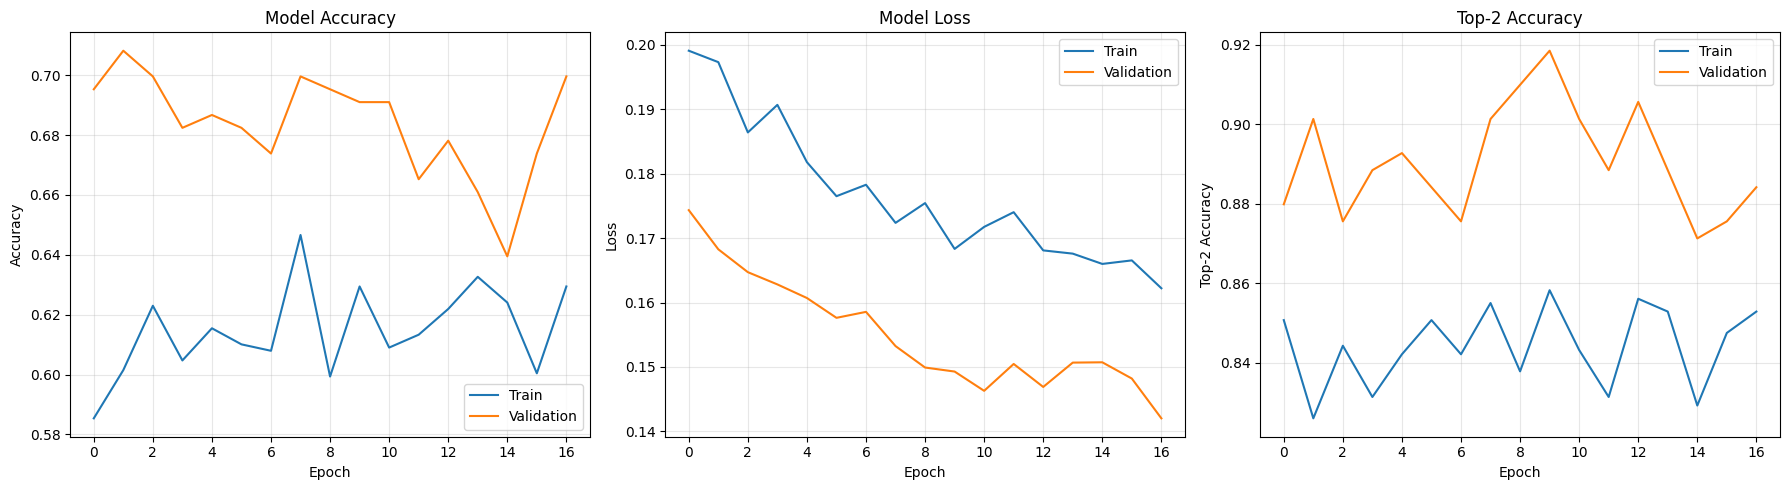

Final Train Accuracy: 62.94%
Final Val Accuracy:   69.96%
Best Val Accuracy:    70.82%
Best Epoch:           2
Overfitting Gap:      7.87%


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history.history['top2_accuracy'], label='Train')
axes[2].plot(history.history['val_top2_accuracy'], label='Validation')
axes[2].set_title('Top-2 Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Top-2 Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
overfitting_gap = abs(final_train_acc - best_val_acc)

print(f"Final Train Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Val Accuracy:   {final_val_acc*100:.2f}%")
print(f"Best Val Accuracy:    {best_val_acc*100:.2f}%")
print(f"Best Epoch:           {best_epoch}")
print(f"Overfitting Gap:      {overfitting_gap*100:.2f}%")

## 9. Detailed Evaluation

In [24]:
# Load best model
best_model = tf.keras.models.load_model(
    f"{CONFIG['model_save_dir']}/best_model_v7.keras",
    custom_objects={'FocalLoss': FocalLoss}
)
print("Best model loaded")

# Evaluate
results = best_model.evaluate(val_ds, verbose=1)
print(f"\nValidation Accuracy: {results[1]*100:.2f}%")
print(f"Top-2 Accuracy: {results[2]*100:.2f}%")

Best model loaded
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.6789 - loss: 0.4711 - top2_accuracy: 0.8970

Validation Accuracy: 70.82%
Top-2 Accuracy: 90.56%


In [25]:
# Get predictions
print("Generating predictions...")

# Create evaluation dataset without augmentation
val_ds_eval = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds_eval = val_ds_eval.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds_eval = val_ds_eval.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)
val_ds_eval = val_ds_eval.batch(CONFIG['batch_size'])

y_true = []
y_pred = []

for images, labels in val_ds_eval:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = np.mean(y_true == y_pred)
print(f"\nAccuracy: {accuracy*100:.2f}%")

Generating predictions...

Accuracy: 70.82%


In [26]:
# Prediction distribution
pred_counts = {name: 0 for name in class_names}
for p in y_pred:
    pred_counts[class_names[p]] += 1

collapse_detected = False
for class_name, count in pred_counts.items():
    pct = count/len(y_pred)*100
    if pct > 50:
        collapse_detected = True
        print(f"  {class_name}: {count} ({pct:.1f}%) - WARNING")
    else:
        print(f"  {class_name}: {count} ({pct:.1f}%)")

if collapse_detected:
    print("\nClass collapse detected!")
else:
    print("\nPredictions are balanced!")

  artemisia: 60 (25.8%)
  carica: 96 (41.2%)
  goyavier: 25 (10.7%)
  kinkeliba: 52 (22.3%)

Predictions are balanced!


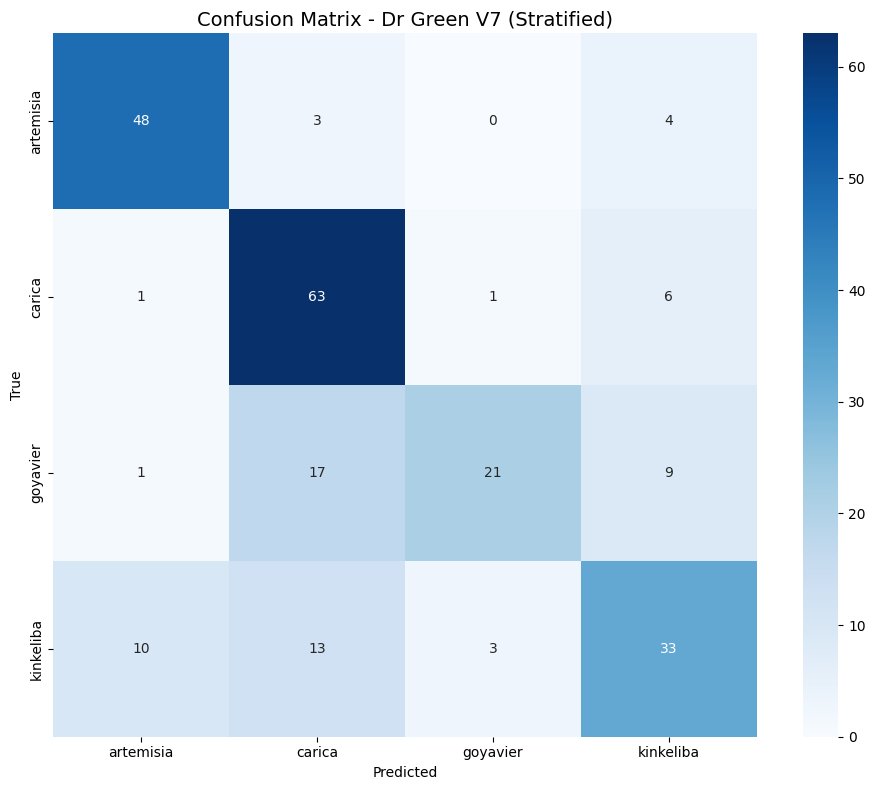

              precision    recall  f1-score   support

   artemisia     0.8000    0.8727    0.8348        55
      carica     0.6562    0.8873    0.7545        71
    goyavier     0.8400    0.4375    0.5753        48
   kinkeliba     0.6346    0.5593    0.5946        59

    accuracy                         0.7082       233
   macro avg     0.7327    0.6892    0.6898       233
weighted avg     0.7226    0.7082    0.6960       233


Per-class accuracy:
  [OK] artemisia: 87.27% (55 samples)
  [OK] carica: 88.73% (71 samples)
  [LOW] goyavier: 43.75% (48 samples)
  [LOW] kinkeliba: 55.93% (59 samples)


In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True
)
plt.title('Confusion Matrix - Dr Green V7 (Stratified)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Per-class accuracy
print("\nPer-class accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = y_true == i
    if class_mask.sum() > 0:
        class_acc = (y_pred[class_mask] == i).mean()
        status = "OK" if class_acc >= 0.60 else "LOW" if class_acc >= 0.40 else "BAD"
        print(f"  [{status}] {class_name}: {class_acc*100:.2f}% ({class_mask.sum()} samples)")

## 10. Download Models

In [29]:
# Production-ready Top-2 prediction functions

class DrGreenPredictor:
    """Production predictor for Dr Green plant identification with Top-2 results."""

    def __init__(self, model_path, class_names=None):
        """
        Initialize the predictor.

        Args:
            model_path: Path to .keras or .tflite model
            class_names: List of class names (default: Dr Green classes)
        """
        self.class_names = class_names or ['artemisia', 'carica', 'goyavier', 'kinkeliba']
        self.img_size = (224, 224)

        # Load model
        if model_path.endswith('.tflite'):
            self.interpreter = tf.lite.Interpreter(model_path=model_path)
            self.interpreter.allocate_tensors()
            self.input_details = self.interpreter.get_input_details()
            self.output_details = self.interpreter.get_output_details()
            self.use_tflite = True
        else:
            self.model = tf.keras.models.load_model(
                model_path,
                custom_objects={'FocalLoss': FocalLoss}
            )
            self.use_tflite = False

        print(f"DrGreenPredictor initialized with {len(self.class_names)} classes")

    def preprocess_image(self, image_path):
        """Load and preprocess image for prediction."""
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.img_size)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return tf.expand_dims(img, 0)

    def predict_top2(self, image_path, return_all=False):
        """
        Get Top-2 predictions for an image.

        Args:
            image_path: Path to the image file
            return_all: If True, also return all class probabilities

        Returns:
            dict: {
                'top1': {'class': str, 'confidence': float, 'rank': 1},
                'top2': {'class': str, 'confidence': float, 'rank': 2},
                'combined_confidence': float,
                'all_probabilities': dict (if return_all=True)
            }
        """
        # Preprocess
        img = self.preprocess_image(image_path)

        # Predict
        if self.use_tflite:
            self.interpreter.set_tensor(self.input_details[0]['index'], img.numpy().astype(np.float32))
            self.interpreter.invoke()
            probs = self.interpreter.get_tensor(self.output_details[0]['index'])[0]
        else:
            probs = self.model.predict(img, verbose=0)[0]

        # Get top 2 indices
        top2_indices = np.argsort(probs)[::-1][:2]

        result = {
            'top1': {
                'class': self.class_names[top2_indices[0]],
                'confidence': float(probs[top2_indices[0]]),
                'rank': 1
            },
            'top2': {
                'class': self.class_names[top2_indices[1]],
                'confidence': float(probs[top2_indices[1]]),
                'rank': 2
            },
            'combined_confidence': float(probs[top2_indices[0]] + probs[top2_indices[1]])
        }

        if return_all:
            result['all_probabilities'] = {
                self.class_names[i]: float(probs[i])
                for i in range(len(self.class_names))
            }

        return result

    def format_for_api(self, image_path):
        """
        Format prediction for FastAPI response.

        Returns:
            dict: API-ready response format
        """
        result = self.predict_top2(image_path, return_all=True)

        return {
            'success': True,
            'predictions': [
                {
                    'plant_name': result['top1']['class'],
                    'confidence': round(result['top1']['confidence'] * 100, 2),
                    'rank': 1
                },
                {
                    'plant_name': result['top2']['class'],
                    'confidence': round(result['top2']['confidence'] * 100, 2),
                    'rank': 2
                }
            ],
            'combined_confidence': round(result['combined_confidence'] * 100, 2),
            'all_classes': {
                k: round(v * 100, 2)
                for k, v in result['all_probabilities'].items()
            }
        }

In [32]:
# Demonstrate Top-2 predictions on validation images

# Initialize predictor with best model
predictor = DrGreenPredictor(f"{CONFIG['model_save_dir']}/best_model_v7.keras")

# Test on a few validation images
print("TOP-2 PREDICTION EXAMPLES")

# Get sample images from each class
samples_per_class = 2
test_images = []

for i, class_name in enumerate(class_names):
    class_indices = np.where(val_labels == i)[0][:samples_per_class]
    for idx in class_indices:
        test_images.append((val_paths[idx], class_name))

# Show predictions
for img_path, true_class in test_images:
    result = predictor.predict_top2(img_path)

    top1 = result['top1']
    top2 = result['top2']

    # Check if correct in top 2
    correct_top1 = "CORRECT" if top1['class'] == true_class else ""
    correct_top2 = "CORRECT" if top2['class'] == true_class else ""
    in_top2 = top1['class'] == true_class or top2['class'] == true_class

    print(f"\nTrue: {true_class}")
    print(f"  1. {top1['class']}: {top1['confidence']*100:.1f}% {correct_top1}")
    print(f"  2. {top2['class']}: {top2['confidence']*100:.1f}% {correct_top2}")
    print(f"  In Top-2: {'YES' if in_top2 else 'NO'}")

DrGreenPredictor initialized with 4 classes
TOP-2 PREDICTION EXAMPLES

True: artemisia
  1. artemisia: 50.9% CORRECT
  2. carica: 29.6% 
  In Top-2: YES

True: artemisia
  1. artemisia: 84.8% CORRECT
  2. kinkeliba: 7.0% 
  In Top-2: YES

True: carica
  1. carica: 55.4% CORRECT
  2. kinkeliba: 24.0% 
  In Top-2: YES

True: carica
  1. carica: 29.4% CORRECT
  2. goyavier: 28.7% 
  In Top-2: YES

True: goyavier
  1. kinkeliba: 36.9% 
  2. carica: 35.5% 
  In Top-2: NO

True: goyavier
  1. carica: 39.9% 
  2. goyavier: 33.4% CORRECT
  In Top-2: YES

True: kinkeliba
  1. kinkeliba: 49.6% CORRECT
  2. artemisia: 24.6% 
  In Top-2: YES

True: kinkeliba
  1. kinkeliba: 35.7% CORRECT
  2. artemisia: 27.9% 
  In Top-2: YES


In [33]:
# Get API format for one image
sample_path = val_paths[0]
api_response = predictor.format_for_api(sample_path)

import json
print(json.dumps(api_response, indent=2))

print("FASTAPI INTEGRATION")


fastapi_code = '''
# FastAPI endpoint for Dr Green

from fastapi import FastAPI, UploadFile, File
from drgreen_predictor import DrGreenPredictor
import tempfile
import os

app = FastAPI()
predictor = DrGreenPredictor("models/drgreen_v2.tflite")

@app.post("/predict")
async def predict_plant(image: UploadFile = File(...)):
    """Identify plant from image with Top-2 predictions."""

    # Save uploaded file temporarily
    with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as tmp:
        content = await image.read()
        tmp.write(content)
        tmp_path = tmp.name

    try:
        # Get Top-2 predictions
        result = predictor.format_for_api(tmp_path)
        return result
    finally:
        os.unlink(tmp_path)
'''

print(fastapi_code)

{
  "success": true,
  "predictions": [
    {
      "plant_name": "carica",
      "confidence": 55.45,
      "rank": 1
    },
    {
      "plant_name": "kinkeliba",
      "confidence": 23.98,
      "rank": 2
    }
  ],
  "combined_confidence": 79.42,
  "all_classes": {
    "artemisia": 3.33,
    "carica": 55.45,
    "goyavier": 17.25,
    "kinkeliba": 23.98
  }
}
FASTAPI INTEGRATION

# FastAPI endpoint for Dr Green

from fastapi import FastAPI, UploadFile, File
from drgreen_predictor import DrGreenPredictor
import tempfile
import os

app = FastAPI()
predictor = DrGreenPredictor("models/drgreen_v2.tflite")

@app.post("/predict")
async def predict_plant(image: UploadFile = File(...)):
    """Identify plant from image with Top-2 predictions."""
    
    # Save uploaded file temporarily
    with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as tmp:
        content = await image.read()
        tmp.write(content)
        tmp_path = tmp.name
    
    try:
        # Get Top-2 predic